# reffrence  
https://www.kaggle.com/martxelo/fe-and-ensemble-mlp-and-lgbm

In [1]:
import numpy as np 
import pandas as pd

In [2]:
# imports
%matplotlib inline

import gc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from keras.models import Model
from keras.optimizers import Adagrad
import keras.layers as L
import lightgbm as lgb
# import xgboost as xgb
import pickle

Using TensorFlow backend.


In [3]:
MLP_EPOCH_NUM = 30
LGBM_BOOST_NUM = 3000
FOLD_NUM = 5

# Load data

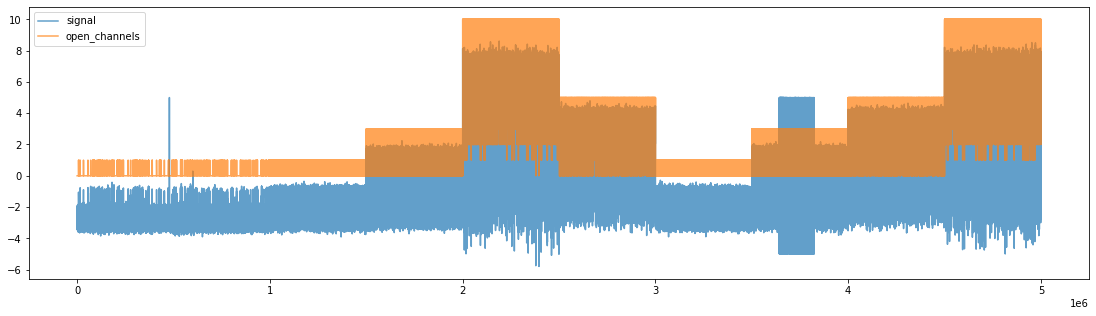

In [4]:
# read data
data = pd.read_csv('../input/data-without-drift/train_clean.csv')
data.head()
data[["signal", "open_channels"]].plot(figsize=(19,5), alpha=0.7);

In [5]:
import random
import tensorflow as tf
import numpy as np
import os

from sklearn.model_selection import GroupKFold
GROUP_BATCH_SIZE = 4000
SEED = 321
SPLITS = 5

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def get_cv(df):
    batch_size = GROUP_BATCH_SIZE
    group = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    group =group.astype(np.uint16)
    
    seed_everything(SEED)
    
    kf = GroupKFold(n_splits=5)
    cv = kf.split(df, df, group)
    return list(cv)


cv = get_cv(data)

In [6]:
 for train_idx, val_idx in cv:
        print(val_idx[::100])

[   8000    8100    8200 ... 4999700 4999800 4999900]
[  12000   12100   12200 ... 4979700 4979800 4979900]
[  16000   16100   16200 ... 4983700 4983800 4983900]
[  20000   20100   20200 ... 4995700 4995800 4995900]
[      0     100     200 ... 4991700 4991800 4991900]


# Feature engineering
Add to signal several other signals: gradients, rolling mean, std, low/high pass filters...

FE is the same as this notebook https://www.kaggle.com/martxelo/fe-and-simple-mlp with corrections in filters.

In [7]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [8]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.9, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [9]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.9, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [10]:
def calc_roll_stats(s, windows=[3, 5, 10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_mean_s_' + str(w)] = s.rolling(window=w, min_periods=1).mean().shift(-w)
        roll_stats['roll_std_s_' + str(w)] = s.rolling(window=w, min_periods=1).std().shift(-w)
        roll_stats['roll_min_s_' + str(w)] = s.rolling(window=w, min_periods=1).min().shift(-w)
        roll_stats['roll_max_s_' + str(w)] = s.rolling(window=w, min_periods=1).max().shift(-w)
        roll_stats['roll_range_s_' + str(w)] = roll_stats['roll_max_s_' + str(w)] - roll_stats['roll_min_s_' + str(w)]
        roll_stats['roll_min_abs_' + str(w)] = s.rolling(window=2*w, min_periods=1).min().abs().shift(-w)
        roll_stats['roll_range_sbs_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_abs_' + str(w)].shift(-w)
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.10).shift(-w)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.25).shift(-w)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.50).shift(-w)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.75).shift(-w)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.90).shift(-w)
        roll_stats['mean_abs_chg' + str(w)] = roll_stats.apply(lambda x: np.mean(np.abs(np.diff(x))))
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [11]:
def calc_ewm(s, windows=[10, 50, 100, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [12]:
def add_features(s):
    '''
    All calculations together
    '''
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm], axis=1)


def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    df = pd.concat(ls, axis=0)
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    df['signal_shift_+2'] = [0,] + [1,] + list(df['signal'].values[:-2])
    df['signal_shift_-2'] = list(df['signal'].values[2:]) + [0] + [1]
    df['signal_shift_+3'] = [0,] + [1,] + [1,] + list(df['signal'].values[:-3])
    df['signal_shift_-3'] = list(df['signal'].values[3:]) + [0] + [1] + [2]
    return df

In [13]:
# apply every feature to data
df = divide_and_add_features(data['signal'])
df.head()

100%|██████████| 10/10 [02:21<00:00, 14.11s/it]


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0133,lowpass_ff_0.0133,lowpass_lf_0.0176,...,ewm_mean_100,ewm_std_100,ewm_mean_1000,ewm_std_1000,signal_shift_+1,signal_shift_-1,signal_shift_+2,signal_shift_-2,signal_shift_+3,signal_shift_-3
0,-0.184000,-0.006380,0.018133,-0.019688,0.001474,-0.184000,-0.186104,-0.184000,-0.186320,-0.184000,...,-0.184000,0.000000,-0.184000,0.000000,0.000000,-0.190380,0.000000,-0.160493,0.00000,-0.209360
1,-0.190380,0.011753,-0.001555,-0.018214,0.013497,-0.184099,-0.186085,-0.184130,-0.186321,-0.184171,...,-0.187222,0.004511,-0.187193,0.004511,-0.184000,-0.160493,1.000000,-0.209360,1.00000,-0.210167
2,-0.160493,-0.009490,-0.018295,0.007305,0.018674,-0.183831,-0.186072,-0.183776,-0.186331,-0.183702,...,-0.178134,0.015830,-0.178275,0.015749,-0.190380,-0.209360,-0.184000,-0.210167,1.00000,-0.176120
3,-0.209360,-0.024837,0.013055,0.019133,-0.008792,-0.183865,-0.186064,-0.183822,-0.186352,-0.183768,...,-0.186176,0.020348,-0.186070,0.020180,-0.160493,-0.210167,-0.190380,-0.176120,-0.18400,-0.179953
4,-0.210167,0.016620,0.019972,-0.010280,-0.016318,-0.184666,-0.186045,-0.184880,-0.186353,-0.185164,...,-0.191168,0.020639,-0.190909,0.020533,-0.209360,-0.176120,-0.160493,-0.179953,-0.19038,-0.172900


Let's plot the signals to see how they look like.

In [14]:
from tqdm import tqdm

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df
df = reduce_mem_usage(df)

100%|██████████| 185/185 [04:03<00:00,  1.31s/it]

Memory usage after optimization is: 1802.44 MB
Decreased by 74.6%


In [16]:
df

,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0133,lowpass_ff_0.0133,lowpass_lf_0.0176,...,ewm_mean_100,ewm_std_100,ewm_mean_1000,ewm_std_1000,signal_shift_+1,signal_shift_-1,signal_shift_+2,signal_shift_-2,signal_shift_+3,signal_shift_-3
0,-0.183960,-0.006378,0.018127,-0.019684,0.001474,-0.183960,-0.186157,-0.183960,-0.186279,-0.183960,...,-0.183960,0.000000,-0.183960,0.000000,0.000000,-0.190430,0.000000,-0.160522,0.000000,-0.209351
1,-0.190430,0.011757,-0.001555,-0.018219,0.013496,-0.184082,-0.186035,-0.184082,-0.186279,-0.184204,...,-0.187256,0.004513,-0.187134,0.004513,-0.183960,-0.160522,1.000000,-0.209351,1.000000,-0.210205
2,-0.160522,-0.009491,-0.018295,0.007305,0.018677,-0.183838,-0.186035,-0.183716,-0.186279,-0.183716,...,-0.178101,0.015823,-0.178223,0.015747,-0.190430,-0.209351,-0.183960,-0.210205,1.000000,-0.176147
3,-0.209351,-0.024841,0.013054,0.019135,-0.008789,-0.183838,-0.186035,-0.183838,-0.186401,-0.183716,...,-0.186157,0.020355,-0.186035,0.020187,-0.160522,-0.210205,-0.190430,-0.176147,-0.183960,-0.179932
4,-0.210205,0.016617,0.019974,-0.010277,-0.016312,-0.184692,-0.186035,-0.184937,-0.186401,-0.185181,...,-0.191162,0.020645,-0.190918,0.020538,-0.209351,-0.176147,-0.160522,-0.179932,-0.190430,-0.172852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.194580,-0.055786,0.047821,0.069275,-0.035614,0.297119,0.315430,0.298584,0.320312,0.297119,...,0.289551,0.080017,0.247070,0.099182,0.291504,0.179810,0.279541,0.301025,0.156494,0.375977
499996,0.179810,0.053223,0.076904,-0.030029,-0.068298,0.293701,0.316162,0.293945,0.321289,0.291260,...,0.287354,0.080688,0.246948,0.099121,0.194580,0.301025,0.291504,0.375977,0.279541,0.358643
499997,0.301025,0.098083,-0.012238,-0.067322,0.006542,0.291992,0.316895,0.291748,0.322510,0.288574,...,0.287598,0.079895,0.247070,0.099060,0.179810,0.375977,0.194580,0.358643,0.291504,0.000000
499998,0.375977,0.028763,-0.057709,-0.016953,0.039459,0.293457,0.317627,0.293701,0.323730,0.291260,...,0.289307,0.080078,0.247314,0.099121,0.301025,0.358643,0.179810,0.000000,0.194580,1.000000


In [17]:
# # read m_data
# m_data = pd.read_csv('../input/viterbi/Viterbi_train.csv', names=["gb", "signal"])
# m_data.head()
# m_data[["signal"]].plot(figsize=(19,5), alpha=0.7)
# df["m_signal"] = m_data["signal"][:-1].values/15

# df = reduce_mem_usage(df)

df_columns = df.columns

In [37]:
# df.reset_index().astype('float32').to_feather('df.feather')

# Classes weights

In [18]:
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

# Build a MLP model

In [19]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [20]:
def lgb_Metric(preds, dtrain):
    labels = dtrain.get_label()
    num_labels = 11
    preds = preds.reshape(num_labels, len(preds)//num_labels)
    preds = np.argmax(preds, axis=0)
    score = f1_score(labels, preds, average="macro")
    return ('KaggleMetric', score, True)

lgb_r_params = {
    'objective': 'multiclass',
    'num_class': 11,
    'metric': 'multi_logloss',
    'learning_rate': 0.00987173774816051,
    'lambda_l1': 0.00031963798315506463,
    'lambda_l2': 0.18977456778807847,
    'num_leaves': 171, 
    'feature_fraction': 0.58733782457345, 
    'bagging_fraction': 0.7057826081907392, 
    'bagging_freq': 4}

In [21]:
import pandas as pd
test_data = pd.read_csv('../input/data-without-drift/test_clean.csv')

test_df = divide_and_add_features(test_data['signal'])
test_df = reduce_mem_usage(test_df)
# read m_data

# m_data = pd.read_csv('../input/viterbi/Viterbi_test.csv').rename(columns={"open_channels": "signal"})
# m_data.head()
# m_data[["signal"]].plot(figsize=(19,5), alpha=0.7)
# test_df["m_signal"] = m_data["signal"].values/15
# test_df = reduce_mem_usage(test_df)
test_df.shape

100%|██████████| 185/185 [01:20<00:00,  2.30it/s]

Memory usage after optimization is: 720.98 MB
Decreased by 74.6%


(2000000, 185)

In [32]:
test_df.index.unique()

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            499990, 499991, 499992, 499993, 499994, 499995, 499996, 499997,
            499998, 499999],
           dtype='int64', length=500000)

In [35]:
len(test_df.index)/4

500000.0

In [38]:
test_df.reset_index().astype('float32').to_feather('test_df.feather')

[   8000    8100    8200 ... 4999700 4999800 4999900]
[  12000   12100   12200 ... 4979700 4979800 4979900]
[  16000   16100   16200 ... 4983700 4983800 4983900]
[  20000   20100   20200 ... 4995700 4995800 4995900]
[      0     100     200 ... 4991700 4991800 4991900]
Fold : 0
sep: (4000000, 185), (1000000, 185), (4000000,), (1000000,)
Train on 4000000 samples, validate on 1000000 samples
Epoch 1/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.1251 - sparse_categorical_accuracy: 0.9546 - val_loss: 0.1064 - val_sparse_categorical_accuracy: 0.9628
Epoch 2/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0905 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1034 - val_sparse_categorical_accuracy: 0.9639
Epoch 3/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9657 - val_loss: 0.1169 - val_sparse_categorical_accuracy: 0.9581
Epoch 4/30
4000000/4000000 [============

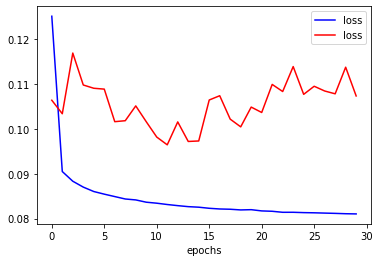

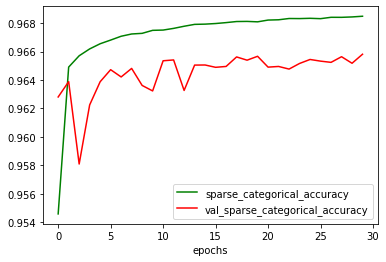

Training LGBM...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	train's multi_logloss: 1.01707	train's KaggleMetric: 0.939182	valid's multi_logloss: 1.02689	valid's KaggleMetric: 0.935468
LGBM trained!
weak fe##############
{'lowpass_lf_0.0100': 157, 'lowpass_lf_0.0133': 138, 'lowpass_lf_0.0176': 133, 'lowpass_lf_0.0233': 126, 'lowpass_lf_0.0308': 137, 'lowpass_lf_0.0408': 108, 'lowpass_lf_0.0541': 175, 'highpass_lf_0.0133': 123, 'highpass_lf_0.0176': 99, 'highpass_lf_0.0233': 100, 'highpass_lf_0.0308': 122, 'highpass_lf_0.0408': 169, 'roll_mean_50': 195, 'ewm_mean_50': 115, 'ewm_mean_100': 196}
##############
0.935468007684375
Fold : 1
sep: (4000000, 185), (1000000, 185), (4000000,), (1000000,)
Train on 4000000 samples, validate on 1000000 samples
Epoch 1/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.1314 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.0929 - val_sparse_categorical_accuracy: 0.964

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.0790 - val_sparse_categorical_accuracy: 0.9694
Epoch 20/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.0790 - val_sparse_categorical_accuracy: 0.9694
Epoch 21/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.0804 - val_sparse_categorical_accuracy: 0.9690
Epoch 22/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0833 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.0794 - val_sparse_categorical_accuracy: 0.9694
Epoch 23/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0840 - val_sparse_categorical_accuracy: 0.9674
Epoch 24/30
4000000/4000000 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0845 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.0831 - val_sparse_categorical_accuracy: 0.9676
Epoch 12/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0843 - sparse_categorical_accuracy: 0.9672 - val_loss: 0.0822 - val_sparse_categorical_accuracy: 0.9681
Epoch 13/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0840 - sparse_categorical_accuracy: 0.9673 - val_loss: 0.0821 - val_sparse_categorical_accuracy: 0.9683
Epoch 14/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9674 - val_loss: 0.0813 - val_sparse_categorical_accuracy: 0.9684
Epoch 15/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9675 - val_loss: 0.0817 - val_sparse_categorical_accuracy: 0.9684
Epoch 16/30
4000000/4000000 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0885 - sparse_categorical_accuracy: 0.9657 - val_loss: 0.0892 - val_sparse_categorical_accuracy: 0.9658
Epoch 4/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0877 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.0865 - val_sparse_categorical_accuracy: 0.9666
Epoch 5/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0868 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0856 - val_sparse_categorical_accuracy: 0.9667
Epoch 6/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0861 - sparse_categorical_accuracy: 0.9665 - val_loss: 0.0891 - val_sparse_categorical_accuracy: 0.9655
Epoch 7/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.0860 - val_sparse_categorical_accuracy: 0.9666
Epoch 8/30
4000000/4000000 [==============================] - 28s 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0822 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.0843 - val_sparse_categorical_accuracy: 0.9674
Epoch 24/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.0851 - val_sparse_categorical_accuracy: 0.9672
Epoch 25/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0820 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.0844 - val_sparse_categorical_accuracy: 0.9673
Epoch 26/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.0837 - val_sparse_categorical_accuracy: 0.9673
Epoch 27/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0819 - sparse_categorical_accuracy: 0.9681 - val_loss: 0.0832 - val_sparse_categorical_accuracy: 0.9677
Epoch 28/30
4000000/4000000 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0846 - val_sparse_categorical_accuracy: 0.9668
Epoch 15/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0834 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0883 - val_sparse_categorical_accuracy: 0.9654
Epoch 16/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.0827 - val_sparse_categorical_accuracy: 0.9677
Epoch 17/30
4000000/4000000 [==============================] - 27s 7us/step - loss: 0.0830 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.0835 - val_sparse_categorical_accuracy: 0.9674
Epoch 18/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.0860 - val_sparse_categorical_accuracy: 0.9659
Epoch 19/30
4000000/4000000 [==============================] -

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0818 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9678
Epoch 30/30
4000000/4000000 [==============================] - 28s 7us/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9682 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9678
f1 score is :0.9376130478221021


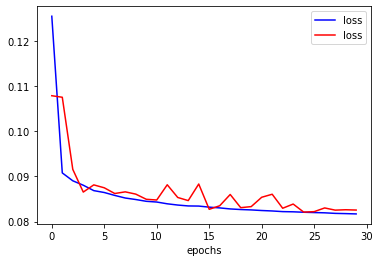

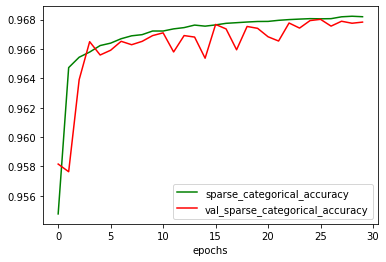

Training LGBM...
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	train's multi_logloss: 0.830882	train's KaggleMetric: 0.939726	valid's multi_logloss: 0.839729	valid's KaggleMetric: 0.935054
LGBM trained!
weak fe##############
{'lowpass_lf_0.0133': 164, 'lowpass_lf_0.0176': 159, 'lowpass_lf_0.0233': 155, 'lowpass_lf_0.0408': 189, 'highpass_lf_0.0133': 193, 'highpass_lf_0.0176': 142, 'highpass_lf_0.0233': 143, 'highpass_lf_0.0308': 174, 'ewm_mean_50': 179}
##############
0.93505359760964


In [48]:
cv = get_cv(data)
for train_idx, val_idx in cv:
        print(val_idx[::100])
        
oof_pred_mlp = np.zeros((5_000_000,11))
test_pred_mlp = np.zeros((2_000_000,11))

oof_pred_lgbm = np.zeros((5_000_000,11))
test_pred_lgbm = np.zeros((2_000_000,11))

# preds = np.zeros(2000000*11).reshape((2000000, 11))

X = df#.values
y = data['open_channels']
y_values = data['open_channels'].values

for i, (tdx, vdx) in enumerate(cv):
    print(f'Fold : {i}')
    X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y_values[tdx], y_values[vdx]
    print(f"sep: {X_train.shape}, {X_valid.shape}, {y_train.shape}, {y_valid.shape}")
    
    mlp = create_mpl(X_train.values[0].shape)

    mlp.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    class_weight = get_class_weight(y_train)

    mlp.fit(x=X_train.values, y=y_train, epochs=MLP_EPOCH_NUM, batch_size=1024, class_weight=class_weight,
           validation_data=(X_valid.values, y_valid), verbose=1)

    
    mlp_pred = mlp.predict(X_valid.values)
    oof_pred_mlp[vdx] = mlp_pred
    
    
    f1_mlp = f1_score(y_valid, np.argmax(mlp_pred, axis=-1), average='macro')
    print(f"f1 score is :{f1_mlp}")
    plt.figure(1)
    plt.plot(mlp.history.history['loss'], 'b', label='loss')
    plt.plot(mlp.history.history['val_loss'], 'r', label='loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.figure(2)
    plt.plot(mlp.history.history['sparse_categorical_accuracy'], 'g', label='sparse_categorical_accuracy')
    plt.plot(mlp.history.history['val_sparse_categorical_accuracy'], 'r', label='val_sparse_categorical_accuracy')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()
    
    # GBC
    lgb_dataset = lgb.Dataset(X_train.values, label=y_train, weight=class_weight[y_train])
    #lgb_valid_dataset = lgb.Dataset(X_valid, label=y_valid, weight=class_weight[y_valid])
    lgb_valid_dataset = lgb.Dataset(X_valid.values, label=y_valid, weight=class_weight[y_valid])
    print('Training LGBM...')
    gbc = lgb.train(lgb_r_params, lgb_dataset, LGBM_BOOST_NUM, valid_names=["train", "valid"], 
                    valid_sets=[lgb_dataset, lgb_valid_dataset], verbose_eval=-1, 
                    feval=lgb_Metric, early_stopping_rounds=10)
    print('LGBM trained!')
    # predict on test
    gbc_pred = gbc.predict(X_valid.values, num_iteration=gbc.best_iteration)
    oof_pred_lgbm[vdx] = gbc_pred
    
    attr2 = {k: v for k, v in zip(df_columns, gbc.feature_importance()) if 200 > v and v>0}
    print("weak fe##############")
    print(attr2)
    print("##############")

    print(f1_score(y_valid, np.argmax(gbc_pred, axis=1), average='macro'))
    

    mlp_pred = mlp.predict(test_df)
    test_pred_mlp += mlp_pred/5
    
    gbc_pred = gbc.predict(test_df, num_iteration=gbc.best_iteration)
    test_pred_lgbm += gbc_pred/5
    
    
    gc.collect()


In [49]:
print(f1_score(y_values, np.argmax(oof_pred_mlp, axis=1), average='macro'))
print(f1_score(y_values, np.argmax(oof_pred_lgbm, axis=1), average='macro'))

0.9359868233521224
0.9352293140057089


In [50]:
np.save('oof_pred_mlp.npy', oof_pred_mlp)
np.save('oof_pred_lgbm.npy', oof_pred_lgbm)

np.save('test_pred_mlp.npy', test_pred_mlp)
np.save('test_pred_lgbm.npy', test_pred_lgbm)

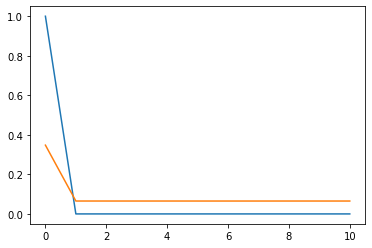

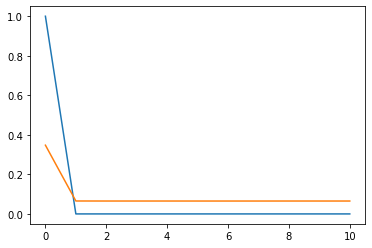

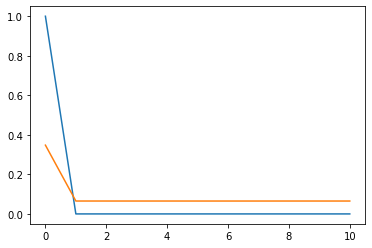

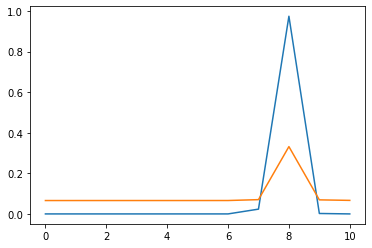

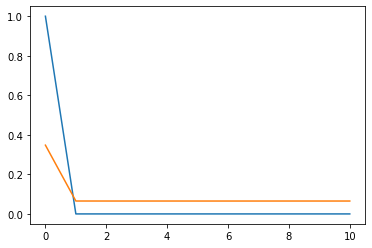

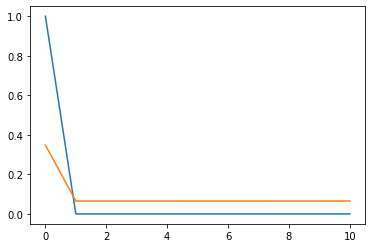

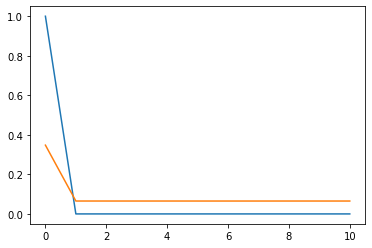

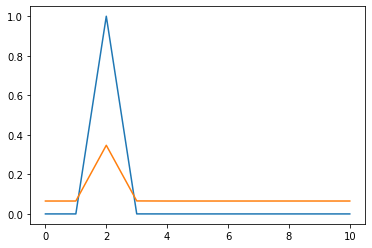

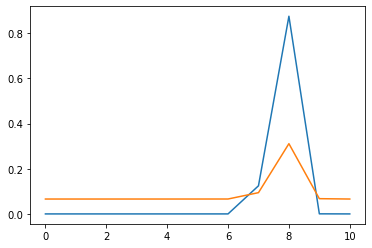

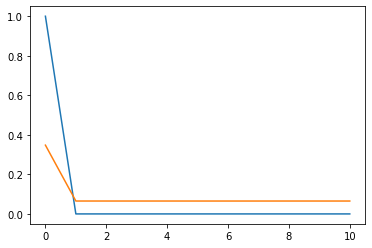

In [64]:
# import matplotlib.pyplot as plt

# a = np.load("../input/knn-oof/oof_knn_feats.npy")
# b = np.load("../input/ion-shifted-rfc-proba/Y_train_proba.npy")

for i in np.random.randint(0, 2000000, size=10):
    print(plt.plot(test_pred_mlp[i]))
    print(plt.plot(test_pred_lgbm[i]))
    plt.show()

In [51]:
def save_sub(preds, name):
    pred = np.argmax(preds, axis=1)
    print('Writing submission...')
    submission = pd.DataFrame()
    submission['time'] = test_data['time']

    submission['open_channels'] = pred
    submission.to_csv(name, index=False, float_format='%.4f')

In [52]:
save_sub(test_pred_mlp, 'test_pred_mlp.csv')
save_sub(test_pred_lgbm, 'test_pred_lgbm.csv')

Writing submission...
Writing submission...


In [66]:
# !kaggle competitions submit -c liverpool-ion-switching -f test_pred_mlp.csv -m "test_pred_mlp"

100%|██████████████████████████████████████| 21.0M/21.0M [00:03<00:00, 5.64MB/s]
Successfully submitted to University of Liverpool - Ion Switching

In [67]:
!kaggle competitions submit -c liverpool-ion-switching -f test_pred_lgbm.csv -m "test_pred_lgbm"

100%|██████████████████████████████████████| 21.0M/21.0M [00:06<00:00, 3.18MB/s]
Successfully submitted to University of Liverpool - Ion Switching

In [69]:
!zip ans oof_pred_lgbm.npy oof_pred_mlp.npy test_pred_lgbm.csv test_pred_mlp.csv test_pred_mlp.npy test_pred_lgbm.npy 

  adding: oof_pred_lgbm.npy (deflated 42%)
  adding: oof_pred_mlp.npy (deflated 55%)
  adding: test_pred_lgbm.csv (deflated 79%)
  adding: test_pred_mlp.csv (deflated 79%)
  adding: test_pred_mlp.npy (deflated 43%)
  adding: test_pred_lgbm.npy (deflated 62%)


In [ ]:
!mv oof_pred_lgbm.npy oof_pred_mlp.npy test_pred_lgbm.csv test_pred_mlp.csv test_pred_mlp.npy test_pred_lgbm.npy lgb-mlp-oof